In [1]:
import os
import sys
import pickle

import pandas as pd
import numpy as np
from matplotlib.pyplot import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

from config import RESULTS, FIGURES
from code_.tools.plotting import *
from code_.model_activations.configs import analysis_cfg

In [2]:
MULTIPLIER = 36

def load_and_prepare_data(model_name, multiplier, dataset, region):
    filepath = os.path.join(RESULTS, f'bootstrap-results-{model_name}-{dataset}-{region}.csv')
    df = pd.read_csv(filepath)
    df['model'] = model_name
    df['features'] = df['features'].apply(lambda x: int(x) * multiplier)
    df['score'] = df['score'].apply(lambda x: float(x.replace("tensor(", "").replace(")", "")))

    return df

In [3]:
DATASET = 'naturalscenes' # one of ['majajhong', 'naturalscenes']
region = analysis_cfg[DATASET]['regions']

# Effect of activation function 

In [4]:
# loading linear model data
df_linear = load_and_prepare_data('expansion_linear', MULTIPLIER, DATASET, region)
# loading linear model data
df_expansion = load_and_prepare_data('expansion', MULTIPLIER, DATASET, region)
#join dataframes
df = pd.concat([df_linear,df_expansion]).reset_index(drop=True)
# alexnet data
df_alexnet = pd.read_csv(os.path.join(RESULTS, f'bootstrap-results-alexnet_trained-{DATASET}-{region}.csv')) 
df_alexnet['score'] = df_alexnet['score'].apply(lambda x: float(x.replace("tensor(", "").replace(")", ""))) 

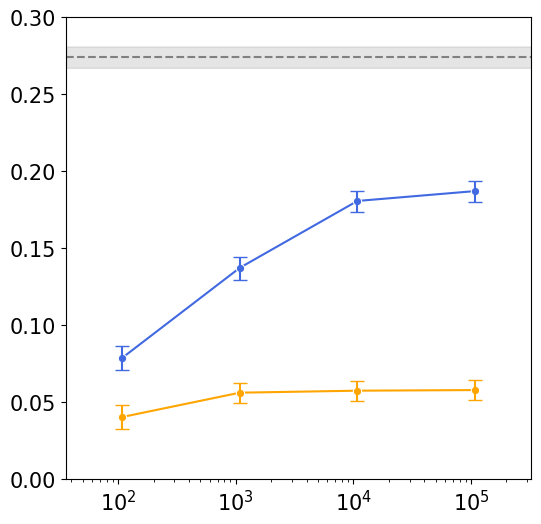

In [5]:
names ={'expansion':'ReLU','expansion_linear':'Linear'}
palette ={'ReLU':'royalblue','Linear':'orange'}
df['model'] = df['model'].map(names)
df['color'] = df['model'].map(palette)

rcParams['figure.figsize'] = (6,6)  

# main plot
ax1 = sns.lineplot(data = df, x='features', y='score', hue='model', marker='o',palette = palette)
# adding error bars for the 95% confidence interval
for i in range(len(df)):
    plt.errorbar(df['features'][i], df['score'][i], 
                 yerr=[[df['score'][i] - df['lower'][i]], 
                       [df['upper'][i] - df['score'][i]]], 
                 fmt='none', capsize=5, color=df['color'][i])


# alexnet results
plt.axhline(y=df_alexnet['score'][0], color='gray', linestyle='--', label='AlexNet')
# adding confidence interval
plt.fill_between(np.arange(df['features'].min()/3,df['features'].max()*3), 
                 df_alexnet['lower'], 
                 df_alexnet['upper'], 
                 color='gray', alpha=0.2)


plt.ylim(0,0.30) if DATASET == 'naturalscenes' else plt.ylim(0,0.65)
plt.xlim(df['features'].min()/3,df['features'].max()*3)
plt.xticks(size=15)
plt.yticks(size=15)
ax1.set_xscale("log")    
plt.xlabel('')
plt.ylabel('')    
ax1.legend(frameon=False,fontsize=12) if region == 'IT' else ax1.legend_.remove()
plt.savefig(os.path.join(FIGURES,f'figure_5_activation_function_{DATASET}_{region}.png'), dpi=200) 
plt.show()

# Effects of local connectivity

In [8]:


# loading linear model data
df_shuffled = load_and_prepare_data('expansion', MULTIPLIER, DATASET+'_shuffled', region)
# loading linear model data
df_expansion = load_and_prepare_data('expansion', MULTIPLIER, DATASET, region)
#join dataframes
df = pd.concat([df_linear,df_expansion]).reset_index(drop=True)

# alexnet data
df_alexnet = pd.read_csv(os.path.join(RESULTS, f'bootstrap-results-alexnet_trained-{DATASET}-{region}.csv')) 
df_alexnet['score'] = df_alexnet['score'].apply(lambda x: float(x.replace("tensor(", "").replace(")", ""))) 

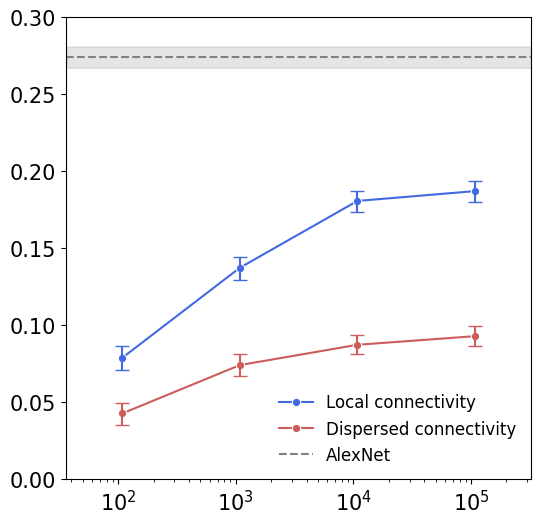

In [9]:
df_expansion['dataset'] = 'Local connectivity'
df_shuffled['dataset'] = 'Dispersed connectivity'
df = pd.concat([df_expansion,df_shuffled]).reset_index(drop=True)
names ={'expansion':'Expansion'}
palette ={'Local connectivity':'royalblue','Dispersed connectivity':'indianred'}
df['model'] = df['model'].map(names)
df['color'] = df['dataset'].map(palette)

rcParams['figure.figsize'] = (6,6)  

# main plot
ax1 = sns.lineplot(data = df, x='features', y='score', hue='dataset', marker='o',palette = palette)
# adding error bars for the 95% confidence interval
for i in range(len(df)):
    plt.errorbar(df['features'][i], df['score'][i], 
                 yerr=[[df['score'][i] - df['lower'][i]], [df['upper'][i] - df['score'][i]]], 
                 fmt='none', capsize=5, color=df['color'][i])
    
# alexnet results
plt.axhline(y=df_alexnet['score'][0], color='gray', linestyle='--', label='AlexNet')
# adding confidence interval
plt.fill_between(np.arange(df['features'].min()/3,df['features'].max()*3), 
                 df_alexnet['lower'], df_alexnet['upper'], color='gray', alpha=0.2)

plt.xlabel('')
plt.ylabel('')
plt.ylim(0,0.30) if DATASET == 'naturalscenes' else plt.ylim(0,0.65)
plt.xlim(df['features'].min()/3,df['features'].max()*3)
plt.xticks(size=15)
plt.yticks(size=15)
ax1.set_xscale("log")    
region == 'IT' if ax1.legend(frameon=False,fontsize=12) else ax1.legend_.remove()  
plt.savefig(os.path.join(FIGURES, f'figure_5_local_connectivity_{DATASET}_{region}.png'), dpi=200) 
plt.show()

# Scaing effect


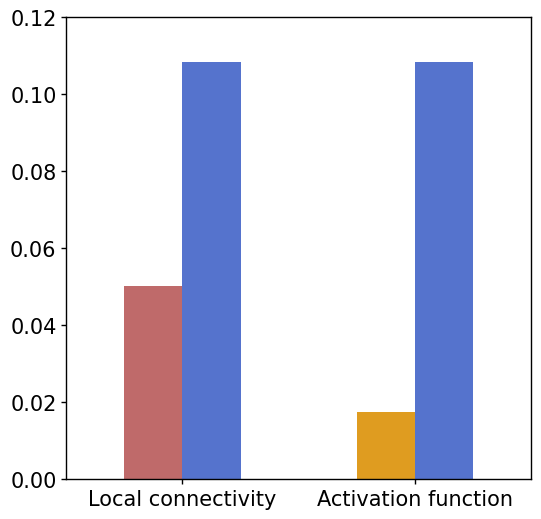

In [10]:
models = ['expansion','expansion_linear','expansion_shuffled']
names = {'expansion': 'Original architecture', 'expansion_linear': 'Linear', 'expansion_shuffled': 'Dispersed connectivity'}
palette ={'Dispersed connectivity':'indianred','Linear':'orange','Original architecture':'royalblue'}

# Configurations for models and features
min_features, max_features = 108,1080000

# Dataset dependent changes
if DATASET == 'naturalscenes':
    max_features/=10

# Data initialization
ratios_dicts = {model: {'region':[], 'dataset':[], 'model':[], 'smallest model score':[], 
                        'largest model score':[], 'difference':[]} 
                for model in models}

for model_name in models:
    if model_name == 'expansion_shuffled':
        df_model = load_and_prepare_data('expansion', MULTIPLIER, DATASET+'_shuffled', region)
    else:
        df_model = load_and_prepare_data(model_name, MULTIPLIER, DATASET, region)
    smallest_score = float(df_model[df_model.features == min_features]['score'].item())
    largest_score = float(df_model[df_model.features == max_features]['score'].item())
    
    ratios_dicts[model_name]['region'].append(region)
    ratios_dicts[model_name]['dataset'].append(DATASET)
    ratios_dicts[model_name]['model'].append(model_name)
    ratios_dicts[model_name]['smallest model score'].append(smallest_score)
    ratios_dicts[model_name]['largest model score'].append(largest_score)
    ratios_dicts[model_name]['difference'].append(largest_score - smallest_score)

# Concatenate all dataframes
df_1 = pd.concat([pd.DataFrame.from_dict(ratios_dicts[model]) for model in ['expansion','expansion_shuffled']]).reset_index(drop=True)
df_1['model'] = df_1['model'].map(names)
df_1['analysis'] = 'Local connectivity'

df_2 = pd.concat([pd.DataFrame.from_dict(ratios_dicts[model]) for model in ['expansion','expansion_linear']]).reset_index(drop=True)
df_2['model'] = df_2['model'].map(names)
df_2['analysis'] = 'Activation function'

# Plot both datasets
ax1 = sns.barplot(
    x='analysis', 
    y='difference', 
    hue='model', 
    palette=palette, 
    data=df_1.sort_values(by='model'),
    width=0.5)
ax2 = sns.barplot(
    x='analysis', 
    y='difference', 
    hue='model', 
    palette=palette, 
    data=df_2.sort_values(by='model'),
    width=0.5)

handles_1, labels_1 = ax1.get_legend_handles_labels()
handles_to_display_1 = [handles_1[1], handles_1[0], handles_1[2]]
labels_to_display_1 = [labels_1[1], labels_1[0], labels_1[2]]
ax1.legend(handles_to_display_1, labels_to_display_1, loc='best', frameon=False, fontsize=12) if region == 'IT' else ax1.legend_.remove()
plt.xlabel('')
plt.ylabel('')
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylim(0,0.3) if 'majajhong' in DATASET else plt.ylim(0,0.12) 
for spine in ax1.spines.values():
    spine.set_linewidth(1)
ax1.xaxis.set_tick_params(width=1)
ax1.yaxis.set_tick_params(width=1)
plt.savefig(os.path.join(FIGURES,f'figure_5_scaling_effect_{DATASET}_{region}.png'), dpi=200) 
plt.show()